# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Group Project
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Assigned Teaching Staff: Patrick 'Likestogiveas' Ohiomoba**<br>
**Due Date: ** Friday, April 27th, 2018 at 11:59pm<br><br>
**Assigned Paper:** Bayesian Incremental Learning for Deep Neural Networks (https://arxiv.org/abs/1802.07329)<br>
**Group Members:** Alex Truong, David Loving, Jonathan Lee


# Background

In many practical applications of machine learning, data are not fully collected prior to model training but arrive in chunks, with accrual possibly over a long time period. For instance, a machine learning model for medical diagnoses may accomodate an initial set of patient data, but the model parameters may need to be further tuned as yet more clinical data are generated. Thus, a method to tweak predictive models using new data would be broadly applicable for a number of applications of machine learning.

Deep learning, or deep neural networks, represents a family of nonparametric machine learning models which have been gaining widespread use due to their flexibility and predictive capabilities in data analysis and artificial intelligence. However, deep learning models are marked by complex parameterization, making it challenging to tune these models. Furthermore, training of these models is prone to reach a suboptimal solution, especially .

Kochurov et al. describe a method to update pre-existing deep learning models with new data using stochastic variational inference and Bayesian networks as opposed to pure DNNs. In this tutorial, we aim to implement key facets of this incremental learning approach with neural networks in a python framework.

# Overview of Methods

## Incremental Learning

To simulate an incremental learning framework, we model a dataset $\mathcal D$ that arrives sequentially in $T$ parts, $\mathcal D = \{\mathcal D_1,...\mathcal D_T\}$ during training. For each sequential addition of data, we train a neural network model on the subset of data, $\mathcal D_t$ and then update our priors on the model weights. Pseudocode from Kochurov et al. is presented below.

<img src="algorithm.png">

We use a pre-trained neural network and weak Gaussian priors on the weights, centered around the pre-trained means with standard deviations of 1. For each chunk of data that arrives, we sample from it and update our parameters using Adam with default settings, as described by Kochurov et al.

### Stochastic Variational Inference

In many cases the posterior distribution is intractable, so approximation must be done in more creative ways. The authors decide upon stochastic variational inference to approximate each weight. Stochastic variational inference is the application of stochastic optimization to variational inference (Hoffman et al., 2013).

In variational inference, the posterior distribution $P(\textbf Z|\textbf X)$ of some set of unknown variables $\textbf Z = \{Z_1,...Z_n\}$ with some observed data $\textbf X$ is approximated by a variational distribution, $Q(\textbf Z)$. $Q(\textbf Z)$ is restricted to the family of distributions that are simpler than $P(\textbf Z|\textbf X)$. The (lack of) similarity between $Q$ and $P$ is determined with a dissimiliarity function, $d(Q;P)$, and variational inference serves to minimize this function. A typical dissimiliarity function is Kullback–Leibler divergence (KL-divergence). It is defined as

$$D_{\mathrm{KL}}(Q || P) = \sum_\mathbf{Z}  Q(\mathbf{Z}) \log \frac{Q(\mathbf{Z})}{P(\mathbf{Z}\mid \mathbf{X})}$$

Minimizing a function like this turns the inference problem into an optimization problem.

Stochastic variational inference applies random sampling of $\mathbf{X}$ and updates model parameters accordingly. Once the minimization of the dissimilarity function is stabilized (converged), we arrive at our approximation of the posterior distribution.

In this tutorial, we focus on the fully factorized gaussian approximation method, as used by the authors. Essentially, this method defines a category of variational distributions which are gaussian distributions, advertised by the authors as "fast, stable and easy to use". As defined by Kochurov et al., "[f]or a dense layer with input and output dimension $I, O$, respectively, the model is":

$$q_{\phi}(w) = \prod_{i=1}^I \prod_{j=1}^O \mathcal N(w_{ij}|\mu_{ij},\sigma_{ij}^2)$$

Of note, the authors mention that this method has low expressivity, which affects the quality of incremental learning.


# Implementation

## Data Preprocessing

In [1]:
import tensorflow as tf
tf_version = float(tf.__version__[:3])
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from edward.models import Normal, Categorical, Deterministic
import edward as ed
import time

c:\Anaconda36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# retrieve MNIST data
mnist = input_data.read_data_sets("mnist_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In order to test incremental updating, we divide the MNIST training dataset into a number of subsets. Below is a utility to generate minibatches of those subets to make training simpler.

In [3]:
# define generator for easily accessing subsets of our mnist data
from random import shuffle

class mnist_subset(object):
    def __init__(self, set_id, batch_size):
        self.n_items = 5500  # 55k samples in 10 sets
        self.batch_size = batch_size
        self.n_batches = self.n_items // batch_size
        self.start_idx = self.n_items*set_id
        self.end_idx = self.start_idx+self.n_items
        self.images = mnist.train.images[self.start_idx:self.end_idx]
        self.labels = mnist.train.labels[self.start_idx:self.end_idx]
        self.idxs = list(range(self.start_idx, self.end_idx))
        self.epochs = 0
        self.on_epoch_end()
        
    def on_epoch_end(self):
        # shuffle and make new batches
        shuffle(self.idxs)
        g = lambda x: x*self.batch_size
        self.batch_idxs = [self.idxs[g(i):g(i+1)] for i in range(self.n_batches+1)]
        self.epochs += 1
        
    def next_batch(self):
        if len(self.batch_idxs) < 1:
            self.on_epoch_end()
        idxs = self.batch_idxs.pop()
        features = mnist.train.images[idxs]
        labels = mnist.train.labels[idxs]
        return features, labels
    
    def __len__(self):
        return self.n_batches
    
    def __iter__(self):
        return self
    
    def __next__(self):
        prev_epoch = self.epochs
        batch = self.next_batch()
        curr_epoch = self.epochs
        if prev_epoch == curr_epoch:
            return batch
        else:
            raise StopIteration()

## Build and Incrementally Train a Neural Network

Our first task is to build a standard neural network and then incrementally train it on each subset of our training data to serve as a baseline for comparison. We expect that the network will suffer from overfitting.

The basic TensorFlow code for building a small neural network and training it on MNIST follows much of the skeleton of https://www.tensorflow.org/versions/r1.1/get_started/mnist/pros. For those without a background in Tensorflow, it would likely make a good companion guide for understanding how we use the Tensorflow framework here.

#### tf.InteractiveSession()

We will start an `InteractiveSession` in order to make tensorflow easier to use. Normally, we first define a compute graph and then launch it in a session. With an interactive session we can be more flexible.

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
tf.set_random_seed(42)

#### Define a Simple Neural Network

In [5]:
# placeholder variables that will be filled with our input data and labels when doing computations
x = tf.placeholder(tf.float32, shape=[None, 784])  # MNIST images are 28*28
y_ = tf.placeholder(tf.float32, shape=[None, 10])  # 10 classes with one-hot encoding

In [6]:
# define the layers of our network - note that for code simplicity
# and clarity, we do not include many best-practices

l1_width = 64
l2_width = 16

# layer 1
w_1 = tf.Variable(tf.truncated_normal(shape=[784, l1_width]), name='w_1')
b_1 = tf.Variable(tf.zeros(shape=[l1_width]), name='b_1')
h_1 = tf.nn.tanh(tf.matmul(x, w_1) + b_1)

# layer 2
w_2 = tf.Variable(tf.truncated_normal(shape=[l1_width, l2_width]), name='w_2')
b_2 = tf.Variable(tf.zeros(shape=[l2_width]), name='b_2')
h_2 = tf.nn.tanh(tf.matmul(h_1, w_2) + b_2)

# layer 3
w_3 = tf.Variable(tf.truncated_normal(shape=[l2_width, 10]), name='w_3')
b_3 = tf.Variable(tf.zeros(shape=[10]), name='b_3')
y = tf.matmul(h_2, w_3) + b_3

#### Define Loss and Accuracy calculations

In [7]:
# define the loss function
if tf_version >= 1.5:  # TensorFlow 1.5 deprecated the previous version of the function
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
else:
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    
# invoke a simple SGD optimizer on the loss function
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cross_entropy)

# operation to calculate accuracy of the network
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Define Training function

In [8]:
def fit(data_generator, n_epochs=100, evaluation_frequency=10):
    
    # store history
    train_accuracy_history = []
    test_accuracy_history = []

    start_time = time.time()

    print('Training on {} samples...'.format(len(data_generator.images)))

    for i in range(n_epochs):    

        # training cycle
        for batch in data_generator:

            # run update step
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})

        # evaluation and status update
        print('Epoch: {}'.format(i+1), end='\r')

        if (i+1)%evaluation_frequency == 0:
            # evaluate accuracy on training data
            train_acc = accuracy.eval(feed_dict={x: data_generator.images, y_: data_generator.labels})*100
            train_accuracy_history.append(train_acc)

            # evaluate accuracy on test data
            test_acc = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})*100
            test_accuracy_history.append(test_acc)
        
        if (i+1)%(evaluation_frequency*2) == 0:
            print('Epoch: {}\t Train Accuracy: {:.1f}%\t Test Accuracy: {:.1f}%'.format(i+1, train_acc, test_acc))

    end_time = time.time()
    delta_time = end_time-start_time
    print('Training completed in {:.1f} seconds'.format(delta_time))
    
    return np.array(train_accuracy_history), np.array(test_accuracy_history)

### Initialize the network and train on each data subset incrementally

In [9]:
# intialize all variables
tf.global_variables_initializer().run()

In [10]:
n_epochs = 200
batch_size = 100

history = {'train': [], 'test': []}

# 10 subsets of data
for i in range(10):
    
    # get a generator for this subset
    print('\n=== Subset {} ==='.format(i))
    data_subset = mnist_subset(i, batch_size)
    
    # call fit with the current subset
    hist = fit(data_subset, n_epochs=n_epochs)
    
    # log performance to compare methods
    history['train'].append(hist[0])
    history['test'].append(hist[1])
    
history['train'] = np.array(history['train']).ravel()
history['test'] = np.array(history['test']).ravel()


=== Subset 0 ===
Training on 5500 samples...
Epoch: 20	 Train Accuracy: 76.3%	 Test Accuracy: 66.9%
Epoch: 40	 Train Accuracy: 84.1%	 Test Accuracy: 71.7%
Epoch: 60	 Train Accuracy: 87.5%	 Test Accuracy: 74.3%
Epoch: 80	 Train Accuracy: 89.6%	 Test Accuracy: 75.5%
Epoch: 100	 Train Accuracy: 91.1%	 Test Accuracy: 76.4%
Epoch: 120	 Train Accuracy: 92.2%	 Test Accuracy: 77.2%
Epoch: 140	 Train Accuracy: 93.0%	 Test Accuracy: 77.6%
Epoch: 160	 Train Accuracy: 93.7%	 Test Accuracy: 77.9%
Epoch: 180	 Train Accuracy: 94.3%	 Test Accuracy: 78.1%
Epoch: 200	 Train Accuracy: 94.7%	 Test Accuracy: 78.3%
Training completed in 19.6 seconds

=== Subset 1 ===
Training on 5500 samples...
Epoch: 20	 Train Accuracy: 88.7%	 Test Accuracy: 80.7%
Epoch: 40	 Train Accuracy: 91.3%	 Test Accuracy: 81.3%
Epoch: 60	 Train Accuracy: 92.5%	 Test Accuracy: 81.7%
Epoch: 80	 Train Accuracy: 93.4%	 Test Accuracy: 82.0%
Epoch: 100	 Train Accuracy: 94.1%	 Test Accuracy: 82.2%
Epoch: 120	 Train Accuracy: 94.7%	 Test A

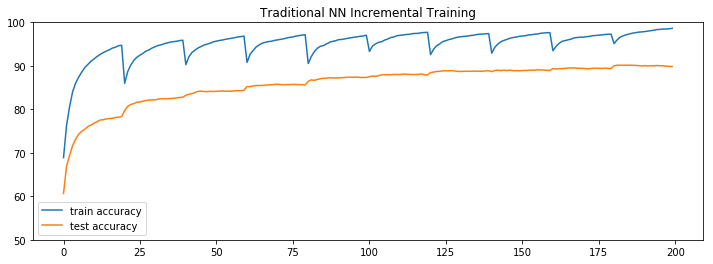

In [11]:
plt.figure(figsize=(12,4))
plt.plot(history['train'], label='train accuracy')
plt.plot(history['test'], label='test accuracy')
plt.legend()
plt.ylim(50,100)
plt.title('Traditional NN Incremental Training');

## Build and Incrementally Train a Neural Network with Variational Inference

#### Clear the graph and get a new session

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
tf.set_random_seed(42)

#### Define a traditional neural network and its Bayesian counterpart

In [13]:
# placeholder variables that will be filled with our input data and labels when doing computations
x = tf.placeholder(tf.float32, shape=[None, 784])  # MNIST images are 28*28
y_ = tf.placeholder(tf.float32, shape=[None, 10])  # 10 classes with one-hot encoding
y_cat_ = tf.placeholder(tf.int32, [None])  #  the Categorical distribution doe not use one-hot encoding

We build the traditional neural network and bayesian incantation side-by-side. The bayesian network is initialized with gaussian priors which are centered at the value of their corresponding parameter in the traditional neural network.

In [14]:
# layer 1
w_1 = tf.Variable(tf.truncated_normal(shape=[784, l1_width]), name='w_1')
b_1 = tf.Variable(tf.zeros(shape=[l1_width]), name='b_1')
h_1 = tf.nn.tanh(tf.matmul(x, w_1) + b_1)

# layer 2
w_2 = tf.Variable(tf.truncated_normal(shape=[l1_width, l2_width]), name='w_2')
b_2 = tf.Variable(tf.zeros(shape=[l2_width]), name='b_2')
h_2 = tf.nn.tanh(tf.matmul(h_1, w_2) + b_2)

# output layer
w_3 = tf.Variable(tf.truncated_normal(shape=[l2_width, 10]), name='w_3')
b_3 = tf.Variable(tf.zeros(shape=[10]), name='b_3')
y = tf.matmul(h_2, w_3) + b_3

In [15]:
# define the loss function
if tf_version >= 1.5:  # TensorFlow 1.5 deprecated the previous version of the function
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
else:
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    
# invoke an SGD optimizer on the loss function
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cross_entropy)

# operation to calculate accuracy of the network
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

So far this should look like the neural network we build earlier. However, next we build the Bayesian network to be fitted with Variational Inference. The first step is to define the model with priors. This is almost identical to the above network, except that rather than using trainable variables for the weights and biases we use Gaussian distributions. We also initialize those distributions using the trained weights and biases of the above network, saving the step of manually shuffling that data around.

In [16]:
# here the Bayesian model and its priors are defined
# their centers are the traditional neural network parameters
# and so will adjust as we train the traditional neural network

# layer 1
bw_1 = Normal(loc=w_1, scale=tf.ones([784, l1_width]))
bb_1 = Normal(loc=b_1, scale=tf.ones(l1_width))
bh_1 = tf.nn.tanh(tf.matmul(x,bw_1)+bb_1)

# layer 2
bw_2 = Normal(loc=w_2, scale=tf.ones([l1_width, l2_width]))
bb_2 = Normal(loc=b_2, scale=tf.ones(l2_width))
bh_2 = tf.nn.tanh(tf.matmul(bh_1,bw_2)+bb_2)

# layer 2
bw_3 = Normal(loc=w_3, scale=tf.ones([l2_width, 10]))
bb_3 = Normal(loc=b_3, scale=tf.ones(10))
bh_3 = Deterministic(tf.nn.softmax(tf.matmul(bh_2,bw_3)+bb_3))

# categorical likelihood for classification
y_cat = Categorical(probs=bh_3)

# operation to calculate accuracy of the network.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now that we have the model and priors constructed, we need to set up the Variational Inference mechanism. We again use Gaussian distributions for each weight and bias in our model.

Note that `tf.get_variable()` and `tf.Variable` both create variables and the use of the former here is simply because we do not need an initializer.

In [17]:
# construct q(w) and q(b) assuming normal distributions   

# layer 1
qw_1 = Normal(loc=tf.get_variable('qw1l', [784, l1_width]),
              scale=tf.nn.softplus(tf.get_variable('qw1s', [784, l1_width])))
qb_1 = Normal(loc=tf.get_variable('qb1l', [l1_width]),
              scale=tf.nn.softplus(tf.get_variable('qb1s', [l1_width])))

# layer 2
qw_2 = Normal(loc=tf.get_variable('qw2l', [l1_width, l2_width]),
              scale=tf.nn.softplus(tf.get_variable('qw2s', [l1_width, l2_width])))
qb_2 = Normal(loc=tf.get_variable('qb2l', [l2_width]),
              scale=tf.nn.softplus(tf.get_variable('qb2s', [l2_width])))

# layer 3
qw_3 = Normal(loc=tf.get_variable('qw3l', [l2_width, 10]),
              scale=tf.nn.softplus(tf.get_variable('qw3s', [l2_width,10])))
qb_3 = Normal(loc=tf.get_variable('qb3l', [10]),
              scale=tf.nn.softplus(tf.get_variable('qb3s', [10])))


# define variational inference technique, ie minimizze KL-divergence
inference = ed.KLqp({bw_1: qw_1, bb_1: qb_1,
                     bw_2: qw_2, bb_2: qb_2,
                     bw_3: qw_3, bb_3: qb_3}, data={y_cat: y_cat_})   

In [19]:
# initialize inference variables
inference.initialize(n_samples=10, n_iter=9900, n_print=10, scale={y: 110})

# initialize any remaining variables
tf.global_variables_initializer().run()

### Pre-Train the DNN on the first set

The code below closely mirrors our `fit` function defined earlier, but that function will not run now because it was defined on a different compute graph.

In [20]:
n_epochs = 200
batch_size = 100

accuracy_eval_frequency = 10

history_with_vi = {'train': [], 'test': []}

# instantiate out data generator
data_generator = mnist_subset(set_id=0, batch_size=batch_size)

for i in range(n_epochs):    

        # training cycle
        for batch in data_generator:

            # run update step
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})

        if (i+1)% accuracy_eval_frequency == 0:

            # evaluate accuracy on training data
            train_acc = accuracy.eval(feed_dict={x: data_generator.images, y_: data_generator.labels})*100

            # evaluate accuracy on test data
            test_acc = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})*100

            history_with_vi['train'].append(train_acc)
            history_with_vi['test'].append(test_acc)
            
            print('Epoch: {}\t Train Accuracy: {:.1f}%\t Test Accuracy: {:.1f}%'.format(i+1, train_acc, test_acc), end='\r')

If we check our priors for the bayesian network, they should now be centered on the parameters we just trained. This is because of how we built our model earlier.

In [21]:
print('DNN:  ', w_1.eval()[0,:5], '\nPrior:',bw_1.loc.eval()[0,:5])

DNN:   [-0.1669705  -0.31707215  1.5395615   0.6512148   0.5023164 ] 
Prior: [-0.1669705  -0.31707215  1.5395615   0.6512148   0.5023164 ]


### Apply Variational Inference on subsequent subsets

In [22]:
accuracy_eval_frequency = 10

start_time = time.time()

for i in range(1,10):
    
    # get data for this subset
    print('\n=== Subset {} ==='.format(i))
    data_generator = mnist_subset(i, batch_size)

    # do variational inference on this subset
    for epoch in range(20):
        
        for batch in data_generator:
            # convert one-hot encoding to single label
            y_batch = np.argmax(batch[1], axis=1)
            info_dict = inference.update(feed_dict={x: batch[0], y_cat_: y_batch})
            inference.print_progress(info_dict)

        # update our dnn weights
        w_1.assign(qw_1.loc).eval()
        b_1.assign(qb_1.loc).eval()
        w_2.assign(qw_2.loc).eval()
        b_2.assign(qb_2.loc).eval()
        w_3.assign(qw_3.loc).eval()
        b_3.assign(qb_3.loc).eval()

        # evaluate accuracy on training data
        train_acc = accuracy.eval(feed_dict={x: data_generator.images, y_: data_generator.labels})*100

        # evaluate accuracy on test data
        test_acc = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})*100

        history_with_vi['train'].append(train_acc)
        history_with_vi['test'].append(test_acc)

    print('\nTrain Accuracy: {:.1f}%\t Test Accuracy: {:.1f}%'.format(train_acc, test_acc))

end_time = time.time()
delta_time = end_time-start_time
print('Training completed in {:.1f} seconds'.format(delta_time))

history_with_vi['train'] = np.array(history_with_vi['train']).ravel()
history_with_vi['test'] = np.array(history_with_vi['test']).ravel()


=== Subset 1 ===
1100/9720 [ 11%] ███                            ETA: 449s | Loss: 156.072
Train Accuracy: 92.3%	 Test Accuracy: 90.5%

=== Subset 2 ===
2200/9720 [ 22%] ██████                         ETA: 299s | Loss: 79.360 
Train Accuracy: 94.1%	 Test Accuracy: 92.0%

=== Subset 3 ===
3300/9720 [ 33%] ██████████                     ETA: 232s | Loss: 62.526
Train Accuracy: 94.1%	 Test Accuracy: 92.7%

=== Subset 4 ===
4400/9720 [ 45%] █████████████                  ETA: 181s | Loss: 155.000
Train Accuracy: 92.8%	 Test Accuracy: 93.0%

=== Subset 5 ===
5500/9720 [ 56%] ████████████████               ETA: 138s | Loss: 47.757
Train Accuracy: 93.6%	 Test Accuracy: 93.2%

=== Subset 6 ===
6600/9720 [ 67%] ████████████████████           ETA: 100s | Loss: 111.447
Train Accuracy: 92.6%	 Test Accuracy: 93.2%

=== Subset 7 ===
7700/9720 [ 79%] ███████████████████████        ETA: 64s | Loss: 101.986
Train Accuracy: 92.1%	 Test Accuracy: 93.3%

=== Subset 8 ===
8800/9720 [ 90%] ████████████████

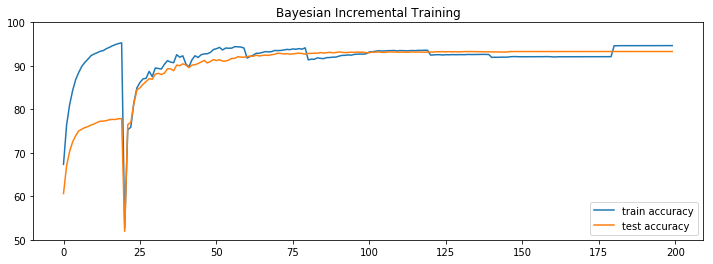

In [23]:
plt.figure(figsize=(12,4))
plt.plot(history_with_vi['train'], label='train accuracy')
plt.plot(history_with_vi['test'], label='test accuracy')
plt.legend()
plt.ylim(50,100)
plt.title('Bayesian Incremental Training');

# Comparison of Methods

## Bayesian vs. Non-Bayesian Incremental Learning

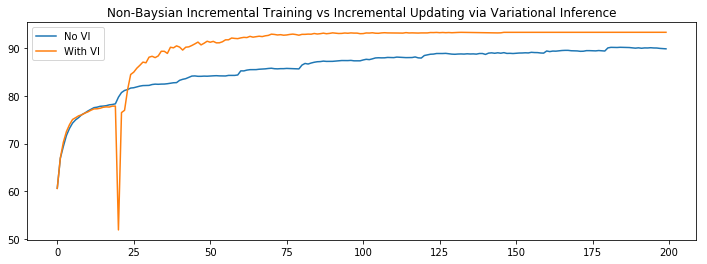

In [24]:
plt.figure(figsize=(12,4))
plt.plot(history['test'], label='No VI')
plt.plot(history_with_vi['test'], label='With VI')
plt.legend()
plt.title('Non-Baysian Incremental Training vs Incremental Updating via Variational Inference');

We see that the VI method makes a large dip at the beginning. This is likely due to poor choices for SD priors. A grid search could be used to optimize this, however we see that the network quickly arrives at good values so we are not concerned about it in this case.

Otherwise, we see that the VI method much more quickly converges and performs significantly better than the traditional method.

## Comparison with Variational Inference Only

Now we will perform incremental variational inference without pre-training the deep neural network. This is almost identical to the above, except our priors for the bayesian neural network are centered at zero and we do not do any training of the non-Bayesian network.

In [25]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
tf.set_random_seed(42)

In [26]:
# placeholder variables that will be filled with our input data and labels when doing computations
x = tf.placeholder(tf.float32, shape=[None, 784])  # MNIST images are 28*28
y_ = tf.placeholder(tf.float32, shape=[None, 10])  # 10 classes with one-hot encoding
y_cat_ = tf.placeholder(tf.int32, [None])  #  the Categorical distribution doe not use one-hot encoding

In [27]:
# layer 1
w_1 = tf.Variable(tf.truncated_normal(shape=[784, l1_width]), name='w_1')
b_1 = tf.Variable(tf.zeros(shape=[l1_width]), name='b_1')
h_1 = tf.nn.tanh(tf.matmul(x, w_1) + b_1)

# layer 2
w_2 = tf.Variable(tf.truncated_normal(shape=[l1_width, l2_width]), name='w_2')
b_2 = tf.Variable(tf.zeros(shape=[l2_width]), name='b_2')
h_2 = tf.nn.tanh(tf.matmul(h_1, w_2) + b_2)

# output layer
w_3 = tf.Variable(tf.truncated_normal(shape=[l2_width, 10]), name='w_3')
b_3 = tf.Variable(tf.zeros(shape=[10]), name='b_3')
y = tf.matmul(h_2, w_3) + b_3

In [28]:
# define the loss function
if tf_version >= 1.5:  # TensorFlow 1.5 deprecated the previous version of the function
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
else:
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    
# invoke an SGD optimizer on the loss function
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cross_entropy)

# operation to calculate accuracy of the network
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [31]:
# here the Bayesian model and its priors are defined
# their centers are ZERO

# layer 1
bw_1 = Normal(loc=tf.zeros([784, l1_width]), scale=tf.ones([784, l1_width]))
bb_1 = Normal(loc=tf.zeros(l1_width), scale=tf.ones(l1_width))
bh_1 = tf.nn.tanh(tf.matmul(x,bw_1)+bb_1)

# layer 2
bw_2 = Normal(loc=tf.zeros([l1_width,l2_width]), scale=tf.ones([l1_width, l2_width]))
bb_2 = Normal(loc=tf.zeros(l2_width), scale=tf.ones(l2_width))
bh_2 = tf.nn.tanh(tf.matmul(bh_1,bw_2)+bb_2)

# layer 2
bw_3 = Normal(loc=tf.zeros([l2_width,10]), scale=tf.ones([l2_width, 10]))
bb_3 = Normal(loc=tf.zeros(10), scale=tf.ones(10))
bh_3 = Deterministic(tf.nn.softmax(tf.matmul(bh_2,bw_3)+bb_3))

# categorical likelihood for classification
y_cat = Categorical(probs=bh_3)

# operation to calculate accuracy of the network.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
# construct q(w) and q(b) assuming normal distributions   

# layer 1
qw_1 = Normal(loc=tf.get_variable('qw1l', [784, l1_width]),
              scale=tf.nn.softplus(tf.get_variable('qw1s', [784, l1_width])))
qb_1 = Normal(loc=tf.get_variable('qb1l', [l1_width]),
              scale=tf.nn.softplus(tf.get_variable('qb1s', [l1_width])))

# layer 2
qw_2 = Normal(loc=tf.get_variable('qw2l', [l1_width, l2_width]),
              scale=tf.nn.softplus(tf.get_variable('qw2s', [l1_width, l2_width])))
qb_2 = Normal(loc=tf.get_variable('qb2l', [l2_width]),
              scale=tf.nn.softplus(tf.get_variable('qb2s', [l2_width])))

# layer 3
qw_3 = Normal(loc=tf.get_variable('qw3l', [l2_width, 10]),
              scale=tf.nn.softplus(tf.get_variable('qw3s', [l2_width,10])))
qb_3 = Normal(loc=tf.get_variable('qb3l', [10]),
              scale=tf.nn.softplus(tf.get_variable('qb3s', [10])))


# define variational inference technique, ie minimizze KL-divergence
inference = ed.KLqp({bw_1: qw_1, bb_1: qb_1,
                     bw_2: qw_2, bb_2: qb_2,
                     bw_3: qw_3, bb_3: qb_3}, data={y_cat: y_cat_})   

In [36]:
# initialize inference variables
inference.initialize(n_samples=10, n_iter=11000, n_print=10, scale={y: 110})

# initialize any remaining variables
tf.global_variables_initializer().run()

In [37]:
accuracy_eval_frequency = 10

history_only_vi = {'train': [], 'test': []}

start_time = time.time()

for i in range(0,10):
    
    # get data for this subset
    print('\n=== Subset {} ==='.format(i))
    data_generator = mnist_subset(i, batch_size)

    # do variational inference on this subset
    for epoch in range(20):
        
        for batch in data_generator:
            # convert one-hot encoding to single label
            y_batch = np.argmax(batch[1], axis=1)
            info_dict = inference.update(feed_dict={x: batch[0], y_cat_: y_batch})
            inference.print_progress(info_dict)

        # update our dnn weights
        w_1.assign(qw_1.loc).eval()
        b_1.assign(qb_1.loc).eval()
        w_2.assign(qw_2.loc).eval()
        b_2.assign(qb_2.loc).eval()
        w_3.assign(qw_3.loc).eval()
        b_3.assign(qb_3.loc).eval()

        # evaluate accuracy on training data
        train_acc = accuracy.eval(feed_dict={x: data_generator.images, y_: data_generator.labels})*100

        # evaluate accuracy on test data
        test_acc = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})*100

        history_only_vi['train'].append(train_acc)
        history_only_vi['test'].append(test_acc)

    print('\nTrain Accuracy: {:.1f}%\t Test Accuracy: {:.1f}%'.format(train_acc, test_acc))

end_time = time.time()
delta_time = end_time-start_time
print('Training completed in {:.1f} seconds'.format(delta_time))

history_only_vi['train'] = np.array(history_only_vi['train']).ravel()
history_only_vi['test'] = np.array(history_only_vi['test']).ravel()


=== Subset 0 ===
 1100/11000 [ 10%] ███                            ETA: 449s | Loss: 463.978
Train Accuracy: 10.7%	 Test Accuracy: 9.9%

=== Subset 1 ===
 2200/11000 [ 20%] ██████                         ETA: 347s | Loss: 433.281
Train Accuracy: 11.3%	 Test Accuracy: 11.3%

=== Subset 2 ===
 3300/11000 [ 30%] █████████                      ETA: 289s | Loss: 410.236
Train Accuracy: 11.8%	 Test Accuracy: 11.3%

=== Subset 3 ===
 4400/11000 [ 40%] ████████████                   ETA: 243s | Loss: 414.848
Train Accuracy: 11.4%	 Test Accuracy: 11.3%

=== Subset 4 ===
 5500/11000 [ 50%] ███████████████                ETA: 200s | Loss: 403.409
Train Accuracy: 11.5%	 Test Accuracy: 11.3%

=== Subset 5 ===
 6600/11000 [ 60%] ██████████████████             ETA: 159s | Loss: 398.908
Train Accuracy: 11.1%	 Test Accuracy: 11.3%

=== Subset 6 ===
 7700/11000 [ 70%] █████████████████████          ETA: 119s | Loss: 404.420
Train Accuracy: 11.7%	 Test Accuracy: 11.3%

=== Subset 7 ===
 8800/11000 [ 80%

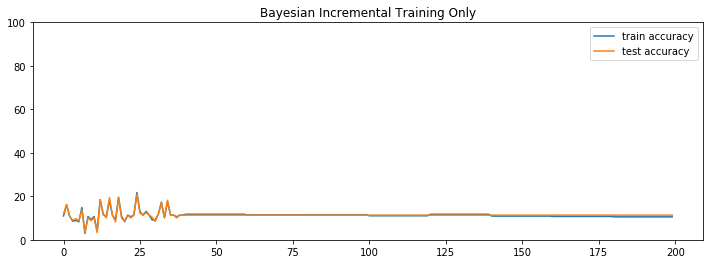

In [38]:
plt.figure(figsize=(12,4))
plt.plot(history_only_vi['train'], label='train accuracy')
plt.plot(history_only_vi['test'], label='test accuracy')
plt.legend()
plt.ylim(0,100)
plt.title('Bayesian Incremental Training Only');

## Final Results

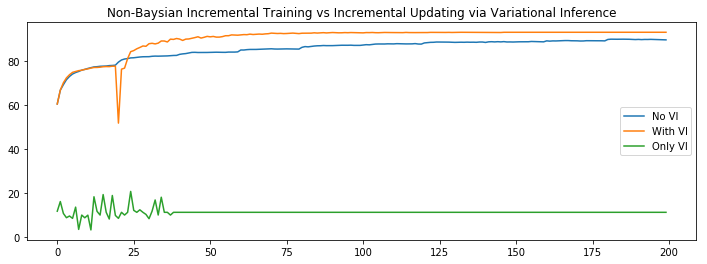

In [39]:
plt.figure(figsize=(12,4))
plt.plot(history['test'], label='No VI')
plt.plot(history_with_vi['test'], label='With VI')
plt.plot(history_only_vi['test'], label='Only VI')
plt.legend()
plt.title('Non-Baysian Incremental Training vs Incremental Updating via Variational Inference');

Without pre-training, the variational technique is unable to optimize the neural network. Clearly, using variational inference to update the pre-trained network is superior to either method on their own.

# Bibliography

Adriano Azevedo-filho. Laplace’s method approximations for probabilistic inference in belief networks
with continuous variables. In In de Mantaras, pp. 28–36. Morgan Kaufmann, 1994.

Matt Hoffman, David M. Blei, Chong Wang, and John Paisley. Stochastic variational inference,
2012.

Max Kochurov, Timur Garipov, Dmitry Podoprikhin, Dmitry Molchanov, Arsenii Ashukha, and Dmitry Vetrov. arXiv:1802.07329, 2018.